# Goal: Correct for singles rate with $W$ calculation
In order to correct for differences in detection efficiencies and solid angles, we will divide all of the doubles rates by the singles rates of the two detectors as follows:

$ W_{i,j} = \frac{D_{i,j}}{S_i*S_j}$

This requires calculating $S_i$ and $S_j$ from the `cced` files. I need to rewrite my analysis from the beginning, or write another function that parses the `cced` file.

In this file, I will import the singles and bicorr data and calculate all  $D_{i,j}$, $S_i$, $S_j$, and $W_{i,j}$. 

This notebook does the analysis in energy space.

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import imageio

In [2]:
import pandas as pd

In [3]:
import seaborn as sns
sns.set(style='ticks')

In [4]:
sys.path.append('../scripts/')

In [5]:
import bicorr as bicorr
import bicorr_e as bicorr_e
import bicorr_plot as bicorr_plot
import bicorr_sums as bicorr_sums
import bicorr_math as bicorr_math

In [6]:
%load_ext autoreload
%autoreload 2

# Load some data

I'm going to work with the data from the combined data sets. The analysis for this data set is in `analysis\Cf072115_to_Cf072215b`.

The one limitation here is that this data has already cut out the fission chamber neighbors. 

## `det_df` without fission chamber neighbors

In [7]:
det_df = bicorr.load_det_df('../meas_info/det_df_pairs_angles.csv')
det_df.head()

,d1,d2,d1d2,angle
0,1,2,102,15.0
1,1,3,103,30.0
2,1,4,104,45.0
3,1,5,105,60.0
4,1,6,106,75.0


In [8]:
chList, fcList, detList, num_dets, num_det_pairs = bicorr.build_ch_lists()
dict_pair_to_index, dict_index_to_pair, dict_pair_to_angle = bicorr.build_dict_det_pair(det_df)

In [9]:
num_fissions = 2194651200.00

## Specify energy range

In [10]:
e_min = 0.62
e_max = 12

## `singles_hist_e_n.npz`

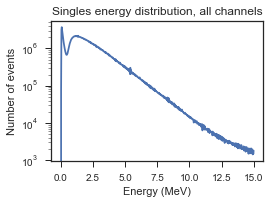

<Figure size 576x396 with 0 Axes>

In [11]:
singles_hist_e_n, e_bin_edges, dict_det_to_index, dict_index_to_det = bicorr_e.load_singles_hist_both(filepath = '../analysis/Cf072115_to_Cf072215b/datap/',plot_flag=True, show_flag=True)

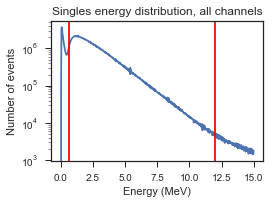

In [12]:
bicorr_plot.plot_singles_hist_e_n(singles_hist_e_n, e_bin_edges, show_flag=False, clear_flag=False)
for e in [e_min, e_max]:
    plt.axvline(e,c='r') 
plt.show()

In [13]:
singles_hist_e_n.shape

(45, 600)

## Load `bhp_nn_e` for all pairs

I'm going to skip a few steps in order to save memory. This data was produced in `analysis_build_bhp_nn_by_pair_1_ns.ipynb` and is stored in `datap\bhp_nn_by_pair_1ns.npz`. Load it now, as explained in the notebook.

In [14]:
bhm_e, e_bin_edges, note = bicorr_e.load_bhm_e('../analysis/Cf072115_to_Cf072215b/datap')

In [15]:
bhm_e.shape

(990, 1, 600, 600)

In [16]:
bhp_e = np.zeros((len(det_df),len(e_bin_edges)-1,len(e_bin_edges)-1))
bhp_e.shape

(990, 600, 600)

In [17]:
for index in det_df.index.values: # index is same as in `bhm`
    bhp_e[index,:,:] = bicorr_e.build_bhp_e(bhm_e,e_bin_edges,pair_is=[index])[0]

C:\Users\pfschus\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


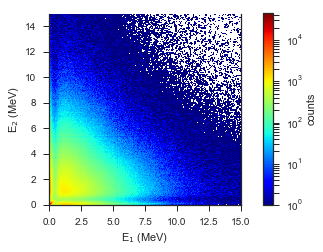

<Figure size 576x396 with 0 Axes>

In [18]:
bicorr_plot.bhp_e_plot(np.sum(bhp_e,axis=0),e_bin_edges, show_flag=True)

## Set up `det_df` columns and `singles_df`

In [19]:
det_df.head()

,d1,d2,d1d2,angle
0,1,2,102,15.0
1,1,3,103,30.0
2,1,4,104,45.0
3,1,5,105,60.0
4,1,6,106,75.0


In [20]:
det_df = bicorr_sums.init_det_df_sums(det_df)
det_df.head()

,d1,d2,d1d2,angle,Cd,Cd_err,Sd1,Sd1_err,Sd2,Sd2_err,W,W_err
0,1,2,102,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,3,103,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,4,104,45.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,5,105,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,6,106,75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
singles_e_df = bicorr_sums.init_singles_e_df(dict_index_to_det)
singles_e_df.head()

,ch,Sd,Sd_err
0,1,NaN,NaN
1,2,NaN,NaN
2,3,NaN,NaN
3,4,NaN,NaN
4,5,NaN,NaN


## Calculate and fill doubles sums

In [22]:
bhp_e.shape

(990, 600, 600)

In [23]:
det_df, energies_real = bicorr_sums.fill_det_df_doubles_e_sums(det_df, bhp_e, e_bin_edges, e_min, e_max, True)
det_df.head()

,d1,d2,d1d2,angle,Cd,Cd_err,Sd1,Sd1_err,Sd2,Sd2_err,W,W_err
0,1,2,102,15.0,23776.0,154.194682,NaN,NaN,NaN,NaN,NaN,NaN
1,1,3,103,30.0,14170.0,119.037809,NaN,NaN,NaN,NaN,NaN,NaN
2,1,4,104,45.0,13777.0,117.375466,NaN,NaN,NaN,NaN,NaN,NaN
3,1,5,105,60.0,13033.0,114.162165,NaN,NaN,NaN,NaN,NaN,NaN
4,1,6,106,75.0,11558.0,107.508139,NaN,NaN,NaN,NaN,NaN,NaN


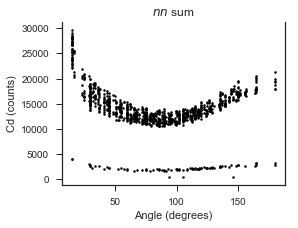

<Figure size 576x396 with 0 Axes>

In [24]:
bicorr_plot.counts_vs_angle_all(det_df, save_flag=False)

## Calculate singles sums

In [25]:
singles_e_df.head()

,ch,Sd,Sd_err
0,1,788117.0,887.759540
1,2,5227204.0,2286.307941
2,3,5083312.0,2254.620145
3,4,5450655.0,2334.663787
4,5,5765819.0,2401.211986


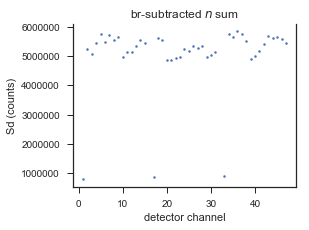

<Figure size 576x396 with 0 Axes>

In [26]:
bicorr_plot.Sd_vs_ch_all(singles_e_df, save_flag=False)

In [27]:
det_df = bicorr_sums.fill_det_df_singles_sums(det_df, singles_e_df)
det_df.head()

,d1,d2,d1d2,angle,Cd,Cd_err,Sd1,Sd1_err,Sd2,Sd2_err,W,W_err
0,1,2,102,15.0,23776.0,154.194682,788117.0,887.75954,5227204.0,2286.307941,NaN,NaN
1,1,3,103,30.0,14170.0,119.037809,788117.0,887.75954,5083312.0,2254.620145,NaN,NaN
2,1,4,104,45.0,13777.0,117.375466,788117.0,887.75954,5450655.0,2334.663787,NaN,NaN
3,1,5,105,60.0,13033.0,114.162165,788117.0,887.75954,5765819.0,2401.211986,NaN,NaN
4,1,6,106,75.0,11558.0,107.508139,788117.0,887.75954,5492867.0,2343.686626,NaN,NaN


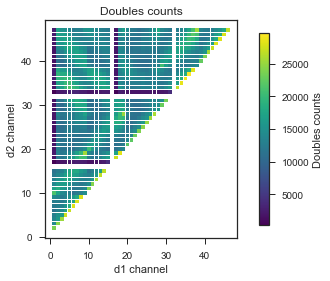

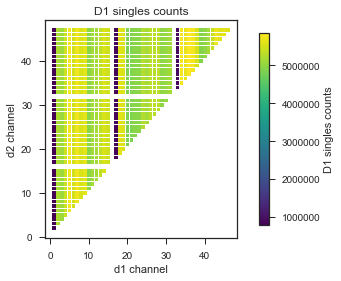

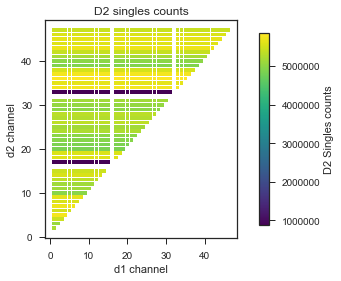

In [28]:
plt.figure(figsize=(4,4))
ax = plt.gca()
sc = ax.scatter(det_df['d1'],det_df['d2'],s=13,marker='s',
                edgecolor = 'none', c=det_df['Cd'],cmap='viridis')
ax.set_xlabel('d1 channel')
ax.set_ylabel('d2 channel')
ax.set_title('Doubles counts')
cbar = plt.colorbar(sc,fraction=0.043,pad=0.1)
cbar.set_label('Doubles counts')
plt.show()

plt.figure(figsize=(4,4))
ax = plt.gca()
sc = ax.scatter(det_df['d1'],det_df['d2'],s=13,marker='s',
                edgecolor = 'none', c=det_df['Sd1'],cmap='viridis')
ax.set_xlabel('d1 channel')
ax.set_ylabel('d2 channel')
ax.set_title('D1 singles counts')
cbar = plt.colorbar(sc,fraction=0.043,pad=0.1)
cbar.set_label('D1 singles counts')
plt.show()

plt.figure(figsize=(4,4))
ax = plt.gca()
sc = ax.scatter(det_df['d1'],det_df['d2'],s=13,marker='s',
                edgecolor = 'none', c=det_df['Sd2'],cmap='viridis')
ax.set_xlabel('d1 channel')
ax.set_ylabel('d2 channel')
ax.set_title('D2 singles counts')
cbar = plt.colorbar(sc,fraction=0.043,pad=0.1)
cbar.set_label('D2 Singles counts')
plt.show()

## Calculate W values

In [29]:
det_df = bicorr_sums.calc_det_df_W(det_df)
det_df.head()

,d1,d2,d1d2,angle,Cd,Cd_err,Sd1,Sd1_err,Sd2,Sd2_err,W,W_err
0,1,2,102,15.0,23776.0,154.194682,788117.0,887.75954,5227204.0,2286.307941,5.771366e-09,3.807325e-11
1,1,3,103,30.0,14170.0,119.037809,788117.0,887.75954,5083312.0,2254.620145,3.536978e-09,3.002001e-11
2,1,4,104,45.0,13777.0,117.375466,788117.0,887.75954,5450655.0,2334.663787,3.207120e-09,2.759560e-11
3,1,5,105,60.0,13033.0,114.162165,788117.0,887.75954,5765819.0,2401.211986,2.868089e-09,2.535796e-11
4,1,6,106,75.0,11558.0,107.508139,788117.0,887.75954,5492867.0,2343.686626,2.669887e-09,2.504164e-11


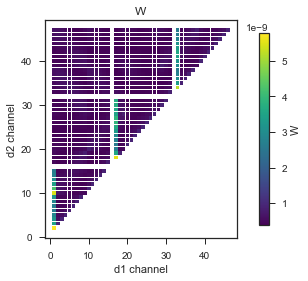

In [30]:
plt.figure(figsize=(4,4))
ax = plt.gca()
sc = ax.scatter(det_df['d1'],det_df['d2'],s=13,marker='s',
                edgecolor = 'none', c=det_df['W'],cmap='viridis')
ax.set_xlabel('d1 channel')
ax.set_ylabel('d2 channel')
ax.set_title('W')
cbar = plt.colorbar(sc,fraction=0.043,pad=0.1)
cbar.set_label('W')
plt.show()

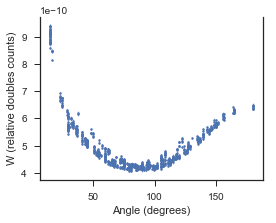

<Figure size 576x396 with 0 Axes>

In [31]:
chIgnore = [1,17,33]
det_df_ignore = det_df[~det_df['d1'].isin(chIgnore) & ~det_df['d2'].isin(chIgnore)]
bicorr_plot.W_vs_angle_all(det_df_ignore, save_flag=False)

In [18]:
bicorr_plot.W_vs_angle_all?

## Condense to angle bin

In [32]:
angle_bin_edges = np.arange(8,190,10)
print(angle_bin_edges)

[  8  18  28  38  48  58  68  78  88  98 108 118 128 138 148 158 168 178
 188]


In [33]:
by_angle_df = bicorr_sums.condense_det_df_by_angle(det_df_ignore, angle_bin_edges)
by_angle_df.head()

,angle_bin_centers,angle_bin_max,angle_bin_min,len pair_is,std_angle,W,W_err,std W
0,13.0,18,8,40.0,0.439220,8.943096e-10,8.920461e-13,2.850903e-11
1,23.0,28,18,17.0,0.705868,6.664925e-10,1.190272e-12,1.355515e-11
2,33.0,38,28,84.0,2.934340,5.755158e-10,4.906239e-13,2.164828e-11
3,43.0,48,38,57.0,1.684873,5.163925e-10,5.618214e-13,1.306246e-11
4,53.0,58,48,53.0,2.414525,4.882797e-10,5.731019e-13,2.717532e-11


## Plot it

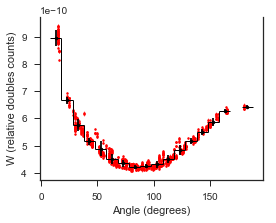

<Figure size 576x396 with 0 Axes>

In [34]:
bicorr_plot.W_vs_angle(det_df_ignore, by_angle_df, save_flag=False)

# Save to disk

In order to compare datasets, it would be nice to save these results to disk and reload in another notebook for comparison. These results are pretty easy, format-wise, so I'll just use the built-in pandas methods.

In [39]:
singles_e_df.to_csv('singles_e_df_filled.csv')

In [40]:
det_df.to_csv(r'det_df_e_filled.csv')

In [41]:
by_angle_df.to_csv(r'by_angle_e_df.csv')

# Reload

In [12]:
det_df_filled = pd.read_csv(r'det_df_e_filled.csv',index_col=0)
det_df_filled.head()

,d1,d2,d1d2,angle,Cd,Cd_err,Sd1,Sd1_err,Sd2,Sd2_err,W,W_err
0,1,2,102,15.0,23776.0,154.194682,788117.0,887.75954,5227204.0,2286.307941,5.771366e-09,3.807325e-11
1,1,3,103,30.0,14170.0,119.037809,788117.0,887.75954,5083312.0,2254.620145,3.536978e-09,3.002001e-11
2,1,4,104,45.0,13777.0,117.375466,788117.0,887.75954,5450655.0,2334.663787,3.207120e-09,2.759560e-11
3,1,5,105,60.0,13033.0,114.162165,788117.0,887.75954,5765819.0,2401.211986,2.868089e-09,2.535796e-11
4,1,6,106,75.0,11558.0,107.508139,788117.0,887.75954,5492867.0,2343.686626,2.669887e-09,2.504164e-11


In [14]:
chIgnore = [1,17,33]
det_df_ignore = det_df_filled[~det_df_filled['d1'].isin(chIgnore) & ~det_df_filled['d2'].isin(chIgnore)]
det_df_ignore.head()

,d1,d2,d1d2,angle,Cd,Cd_err,Sd1,Sd1_err,Sd2,Sd2_err,W,W_err
44,2,3,203,15.0,24306.0,155.903817,5227204.0,2286.307941,5083312.0,2254.620145,9.147392e-10,5.894934e-12
45,2,4,204,30.0,16141.0,127.047235,5227204.0,2286.307941,5450655.0,2334.663787,5.665161e-10,4.472565e-12
46,2,5,205,45.0,15363.0,123.947570,5227204.0,2286.307941,5765819.0,2401.211986,5.097363e-10,4.124022e-12
47,2,6,206,60.0,13146.0,114.656007,5227204.0,2286.307941,5492867.0,2343.686626,4.578520e-10,4.003054e-12
48,2,7,207,75.0,12933.0,113.723349,5227204.0,2286.307941,5730066.0,2393.755627,4.317876e-10,3.805796e-12


In [7]:
singles_e_df_filled = pd.read_csv(r'singles_e_df_filled.csv',index_col=0)
singles_e_df_filled.head()

,ch,Sd,Sd_err
0,1,788117.0,887.759540
1,2,5227204.0,2286.307941
2,3,5083312.0,2254.620145
3,4,5450655.0,2334.663787
4,5,5765819.0,2401.211986


In [8]:
by_angle_e_df = pd.read_csv(r'by_angle_e_df.csv',index_col=0)
by_angle_e_df.head()

,angle_bin_centers,angle_bin_max,angle_bin_min,len pair_is,std_angle,W,W_err,std W
0,13.0,18,8,40.0,0.439220,8.943096e-10,8.920461e-13,2.850903e-11
1,23.0,28,18,17.0,0.705868,6.664925e-10,1.190272e-12,1.355515e-11
2,33.0,38,28,84.0,2.934340,5.755158e-10,4.906239e-13,2.164828e-11
3,43.0,48,38,57.0,1.684873,5.163925e-10,5.618214e-13,1.306246e-11
4,53.0,58,48,53.0,2.414525,4.882797e-10,5.731019e-13,2.717532e-11


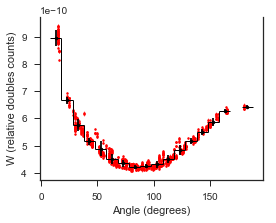

<Figure size 576x396 with 0 Axes>

In [16]:
bicorr_plot.W_vs_angle(det_df_ignore, by_angle_e_df, save_flag=False)